## Network modeling

In this session we will examine methods for characterizing the higher-order structure of a network.  

### Community detection

A common feature of real-world networks is that they exhibit *community structure* - that is, there are groups of individuals who are heavily connected to each other and much less heavily connected to node in other communities. Another way to put this is that edges are *clustered* - and in fact community detection is similar in spirit to clustering.


Let's start with our example of network neuroscience researchers from last week

In [1]:
import os
import pandas,numpy
import networkx as nx
import itertools
from Bio import Entrez
import scipy.cluster
import pickle
import infomap
import igraph
import matplotlib.pyplot as plt
import sklearn

import sys
sys.path.append('../utils')
from utils import get_joint_pubs,nx_to_igraph,module_degree_zscore,participation_coefficient

%matplotlib inline

In [12]:
# If the publication data are cached then load those and use them
# instead of getting them from pubmed
if os.path.exists('../data/pubmed/pubdata.pkl'):
    numpubs=pickle.load(open('../data/pubmed/pubdata.pkl','rb'))
else:
    numpubs={}

researchers={'DB':{'name':'Danielle Bassett'},
            'AF':{'name':'Alex Fornito'},
            'MB':{'name':'Michael Breakspear'},
            'SP':{'name':'Steve Petersen'},
            'MC':{'name':'Michael Cole'},
            'JP':{'name':'Jonathan Power'},
            'DF':{'name':'Damien Fair'},
            'AZ':{'name':'Andrew Zalesky'},
            'MG':{'name':'Matthew Glasser'},
            'VJ':{'name':'Viktor Jirsa'}}

# first get pubmed search terms from names
for i in researchers:
    n_s=researchers[i]['name'].lower().split(' ')
    researchers[i]['pubmed_name']=n_s[1]+'-'+n_s[0][0]


email='bill@gmail.com'  # email address for use by Entrez
for i in itertools.combinations(list(researchers.keys()),2):
    if not i in numpubs:
        # use cached data if present
        numpubs[i]=get_joint_pubs((researchers[i[0]]['pubmed_name'],
                                   researchers[i[1]]['pubmed_name']),
                                   email)


# save pub data
pickle.dump(numpubs,open('../data/pubmed/pubdata.pkl','wb'))

# create a list to use in making the matrix
# do this so that the order stays fixed
researchers_list=list(researchers.keys()) 

# create a data frame to hold all of the entries
# for each combination of researchers

df=pandas.DataFrame(numpy.zeros((len(researchers),
                                 len(researchers))),
                   index=researchers_list,
                   columns=researchers_list)

# we just fill in the upper triangle of the matrix
for i,j in enumerate(researchers_list):
    for k in range(i,len(researchers_list)):
        if i==k:
            continue
        df.loc[j][k]=numpubs[(j,researchers_list[k])]

print(df)

# make binary adjacency matrix
threshold=0
adjacency_mtx=(df>threshold).astype('int')
print(adjacency_mtx)



     DB   AF   MB   SP   MC    JP    DF    AZ   MG   VJ
DB  0.0  2.0  1.0  1.0  3.0   2.0   0.0   1.0  0.0  0.0
AF  0.0  0.0  4.0  0.0  0.0   0.0   0.0  28.0  0.0  0.0
MB  0.0  0.0  0.0  0.0  0.0   0.0   0.0  13.0  0.0  6.0
SP  0.0  0.0  0.0  0.0  1.0  27.0  15.0   0.0  6.0  0.0
MC  0.0  0.0  0.0  0.0  0.0   2.0   0.0   0.0  1.0  0.0
JP  0.0  0.0  0.0  0.0  0.0   0.0   3.0   0.0  3.0  0.0
DF  0.0  0.0  0.0  0.0  0.0   0.0   0.0   0.0  0.0  0.0
AZ  0.0  0.0  0.0  0.0  0.0   0.0   0.0   0.0  0.0  0.0
MG  0.0  0.0  0.0  0.0  0.0   0.0   0.0   0.0  0.0  0.0
VJ  0.0  0.0  0.0  0.0  0.0   0.0   0.0   0.0  0.0  0.0
    DB  AF  MB  SP  MC  JP  DF  AZ  MG  VJ
DB   0   1   1   1   1   1   0   1   0   0
AF   0   0   1   0   0   0   0   1   0   0
MB   0   0   0   0   0   0   0   1   0   1
SP   0   0   0   0   1   1   1   0   1   0
MC   0   0   0   0   0   1   0   0   1   0
JP   0   0   0   0   0   0   1   0   1   0
DF   0   0   0   0   0   0   0   0   0   0
AZ   0   0   0   0   0   0   0   0   0  

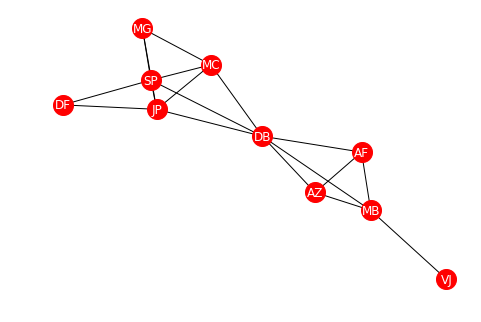

In [3]:
# create network

G = nx.Graph()

G.add_nodes_from(researchers.keys())

matches=numpy.where(adjacency_mtx>0)
for i in range(len(matches[0])):
    G.add_edge(researchers_list[matches[0][i]],
               researchers_list[matches[1][i]])

nx.draw_spring(G,with_labels=True,node_size=400,font_color='white')


Looking at this figure we see a couple of things.  First, we see that there are two communities that are highly connected within each other but relatively unconnected between one another.  Second, we see that there is one person (Dani Bassett) who is highly connected to people in both of those groups.  Let's now look at how we can describe these features using graph theory.

First let's use a standard hierarhical clustering technique to look at the data.

/Users/poldrack/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:7: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  import sys


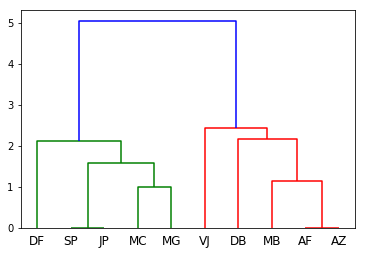

In [180]:
# create a distance matrix based on the binary adjacency matrix
distmtx = 1 - (adjacency_mtx + adjacency_mtx.T).values
# zero out the diagonal
distmtx[numpy.diag_indices_from(distmtx)]=0

# create linkage and plot dendrogram
Z = scipy.cluster.hierarchy.linkage(distmtx, 'ward')
dn = scipy.cluster.hierarchy.dendrogram(Z,labels=adjacency_mtx.columns)

This figure captures some of the features of the graph above, and if we cut the graph at the right point we could create two clusters that would map onto the communities that are clear from the spring-embedded graph.  Now let's see what happens when we use a graph-theoretic method for community detection. 

We will use the Girvan-Newman method, which is succinctly described in the networkx documentation:

>The Girvan–Newman algorithm detects communities by progressively removing edges from the original graph. The algorithm removes the “most valuable” edge, traditionally the edge with the highest betweenness centrality, at each step. As the graph breaks down into pieces, the tightly knit community structure is exposed and the result can be depicted as a dendrogram.

In this case we know that there should be two communities, so we will simply use the algorithm to find the first breakdown into two communities.



In [181]:
comp = nx.algorithms.community.centrality.girvan_newman(G)

# the function creates an iterator, so grab the first item
communities = tuple(sorted(c) for c in next(comp))

# create a partition variable that we can use for labeling the graph
partition=pandas.DataFrame(numpy.zeros(adjacency_mtx.shape[0]),
                          index=adjacency_mtx.columns)
for i,c in enumerate(communities):
    partition.loc[c]=i
partition

,0
DB,0.0
AF,1.0
MB,1.0
SP,0.0
MC,0.0
JP,0.0
DF,0.0
AZ,1.0
MG,0.0
VJ,1.0


Now let's plot the spring-embedded graph using the community partition to color the nodes:

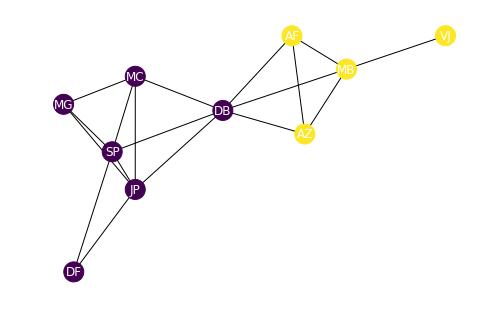

In [182]:
nx.draw_spring(G,with_labels=True,
               node_size=400,
               font_color='white',
               node_color=partition.values)


This shows that the partition found by the Girvan-Newman algorithm identifies the two major communities that are visually evident in the graph.  

It is worth noting that in general one doesn't necessarily know the "right" number of communities in a network, so we generally have to use methods that try to determine the number of communities.  However, like determining the number of clusters in a clustering problem, there is no single right answer for the number of communities.  See [this paper](http://proceedings.mlr.press/v27/luxburg12a/luxburg12a.pdf) for a deeper discussion of this issue in the context of clustering.

### Community detection in complex neworks

Now let's look at the Facebook data from last week's example.


In [ ]:
facebook_data=pandas.read_csv('../data/facebook/facebook_combined.txt',sep=' ',
                             header=None)
# generate a networkx graph
G_facebook=nx.Graph()
for i in facebook_data.index:
    G_facebook.add_edges_from([tuple(facebook_data.loc[i])])


### Modularity 

One of the most common methods for community detection relies upon the concept of modularity, which is a metric that quantifies the degree to which the number of edges within communities exceeds that expected in a random network of similar size and density.  See [here](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1482622/) for a deeper discussion.   

#DIG DEEPER INTO MODULARITY?

A general strategy for community detection is to find the partition that maximizes modularity.  There are a number of methods that can be used to find the network partition that maximizes modularity; this is a hard problem, so most methods use a heuristic approach.  The NetworkX toolbox doesn't include very many of these, but the iGraph toolbox [includes a number of the popular tools for community detection](http://igraph.org/c/doc/igraph-Community.html), so let's use that toolbox instead.  We will use the *multilevel* method [described by Blondel and colleagues](https://arxiv.org/pdf/0803.0476.pdf).  



In [ ]:
ig_facebook = nx_to_igraph(G_facebook) 

ml=ig_facebook.community_multilevel()
unique_partitions=numpy.unique(ml.membership)
print('Louvain method found %d communities'%len(unique_partitions))
for i in unique_partitions:
    print('%d: %d members'%(i,numpy.sum(ml.membership==i)))

Let's plot the spring embedded graph coloring the different communities.

In [ ]:
nx.draw_spring(G_facebook,node_color=ml.membership,
              cmap='tab20',node_size=3,alpha=0.5)

Given this community partition we can also compute the modularity value directly:

In [ ]:
ig_facebook.modularity(ml)

This value is quite high (e.g. see [Table 1](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1482622/table/T1/) of Newman's 2006 PNAS paper), suggesting that there is indeed a strong degree of modular organization in the data (as we would have expected from the graph).

### Infomap

Another commonly used method for community detection in neuroimaging is the [Infomap algorithm](http://www.mapequation.org/code.html), which is also implemented in iGraph.

In [ ]:
infomap_result = ig_facebook.community_infomap()

In [ ]:
unique_partitions=numpy.unique(infomap_result.membership)
print('Infomap method found %d communities'%len(unique_partitions))


As we see, the infomap method with this dataset finds a number of large clusters but also finds many more small clusters.  This highlights one limitation of modularity-based approaches, known as the ["resolution limit"](http://www.pnas.org/content/104/1/36), which prevents them from identifying small clusters (where "small" depends on the size of the network and the degree to which the modules are interconnected). 



### Network hubs

We know that in any group there are some individuals who are better connected than others, and this was evident from the long-tailed degree distrbution in the Facebook data.  In network science, such high-degree nodes are often referred to as "hubs".  Given our characterization of community structure, we can further differentiate between different types of hubs.  Some hubs are both highly connected within their own module and to nodes in other modules, which we refer to as *connector hubs*.  Other hubs are highly connected, but primarily to other nodes within their own module, which we refer to as *provincial hubs*.  These different types of hubs play different roles in network communication, and we will encounter them repeatedly as we discuss network neuroscience research. 

To examine this, let's look at a more realistic network of research publications. To do this, we will search on a set of researchers in the field and find all of their coauthors, and then map their co-publication network.



[1, 1, 1, 0, 0, 0, 0, 1, 0, 1]
0.3317901234567901


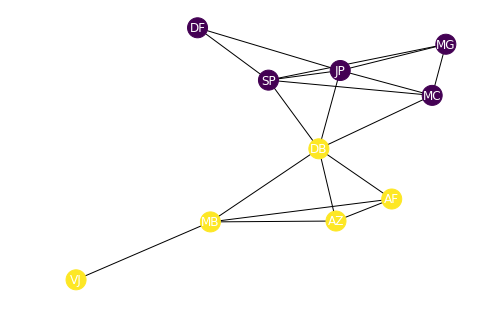

In [4]:
ig_pub = nx_to_igraph(G)
pub_comms = ig_pub.community_multilevel()
print(pub_comms.membership)
print(ig_pub.modularity(pub_comms))

nx.draw_spring(G,with_labels=True,
               node_size=400,
               font_color='white',
               node_color=pub_comms.membership)

A general approach to categorizing different types of hubs was presented by [Guimera and Amaral (2005)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2175124/), known as "cartographic analysis".  This involves computing two node-level measures:

- within-module degree Z-score: 

- participation coefficient: A measure of the squared proportion of edges that are with nodes outside one's own module.

$$P_i = 1 - \sum_{s=1}^{N_M} \left ( \frac{k_{is}}{k_i} \right )^2$$

$k_{is}$ is the number of edges that fall within one's module, and $k_i$ is the total number of edges

In [8]:

mdzs=module_degree_zscore(G, pub_comms.membership)
mdzs


array([ 0.20412415,  0.20412415,  1.22474487,  1.06904497, -0.26726124,
        1.06904497, -1.60356745,  0.20412415, -0.26726124, -1.83711731])

        PC      MDZS  ModDegree
DB  0.7500  0.204124        3.0
AF  0.0000  0.204124        3.0
MB  0.0000  1.224745        4.0
SP  0.3600  1.069045        4.0
MC  0.4375 -0.267261        3.0
JP  0.3600  1.069045        4.0
DF  0.0000 -1.603567        2.0
AZ  0.0000  0.204124        3.0
MG  0.0000 -0.267261        3.0
VJ  0.0000 -1.837117        1.0


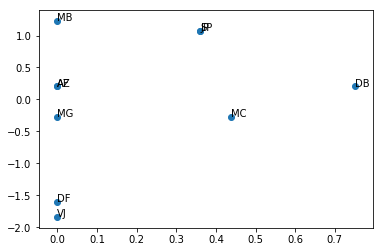

In [10]:

    

pc=participation_coefficient(G,pub_comms.membership)

cartography=pandas.DataFrame(numpy.vstack((pc,
                                           mdzs,
                                           module_degree_zscore(G,pub_comms.membership,zscore=False))).T,
                             columns=['PC','MDZS','ModDegree'],
                            index=adjacency_mtx.index)
print(cartography)
plt.scatter(cartography.PC,cartography.MDZS)
ax=plt.gca()
for i, txt in enumerate(cartography.index):
    ax.annotate(txt, (cartography.PC[i], cartography.MDZS[i]))